In [294]:
from hydradx.model.processing import import_binance_prices
from hydradx.model.amm.global_state import GlobalState, OmnipoolState, historical_prices
from hydradx.model.amm.global_state import liquidate_against_omnipool_and_settle_otc

from hydradx.model.amm.agents import Agent
from hydradx.model.amm.trade_strategies import omnipool_arbitrage, back_and_forth, invest_all
from hydradx.model.amm.omnipool_amm import dynamicadd_lrna_fee, dynamicadd_asset_fee
from hydradx.model import run
from hydradx.model.amm.money_market import MoneyMarket, CDP
from hydradx.model.amm.global_state import update_prices_and_process

import matplotlib.pyplot as plt




# Simulation 1: Historic BTC price crash

In [295]:
vdot_start_price = 9.40
vdot_end_price = 5.72
dot_start_price = 6.96
dot_end_price = 6.93
mins = 60
block_ct = 5 * mins

price_list_padded = []
for i in range(0, block_ct+1):
    pct = i / block_ct
    prices_padded = {'BTC': 60000,
                     'ETH': 3500,
                     'DOT': dot_start_price + pct * (dot_end_price - dot_start_price),
                     'VDOT': vdot_start_price + pct * (vdot_end_price - vdot_start_price),
                     'USDC': 1,
                     'HDX': 0.015,
                     'USDT': 1}
    price_list_padded.append(prices_padded)
print(price_list_padded[0:5])

[{'BTC': 60000, 'ETH': 3500, 'DOT': 6.96, 'VDOT': 9.4, 'USDC': 1, 'HDX': 0.015, 'USDT': 1}, {'BTC': 60000, 'ETH': 3500, 'DOT': 6.9599, 'VDOT': 9.387733333333333, 'USDC': 1, 'HDX': 0.015, 'USDT': 1}, {'BTC': 60000, 'ETH': 3500, 'DOT': 6.9597999999999995, 'VDOT': 9.375466666666666, 'USDC': 1, 'HDX': 0.015, 'USDT': 1}, {'BTC': 60000, 'ETH': 3500, 'DOT': 6.9597, 'VDOT': 9.3632, 'USDC': 1, 'HDX': 0.015, 'USDT': 1}, {'BTC': 60000, 'ETH': 3500, 'DOT': 6.9596, 'VDOT': 9.350933333333334, 'USDC': 1, 'HDX': 0.015, 'USDT': 1}]


In [296]:


assets = {
    'HDX': {'usd price': price_list_padded[0]['HDX'], 'weight': 0.05},
    'USDT': {'usd price': 1, 'weight': 0.10},
    'USDC': {'usd price': price_list_padded[0]['USDC'], 'weight': 0.10},
    'BTC': {'usd price': price_list_padded[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list_padded[0]['ETH'], 'weight': 0.10},
    'DOT': {'usd price': price_list_padded[0]['DOT'], 'weight': 0.30},
    'VDOT': {'usd price': price_list_padded[0]['VDOT'], 'weight': 0.10},
}

lrna_price_usd = 38
initial_omnipool_tvl = 25000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd
    
omnipool = OmnipoolState(
        tokens={
            tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
        },
        # oracles={'fee_raise': 50},
        # lrna_fee=dynamicadd_lrna_fee(
        #     minimum=0.0005,
        #     amplification=1,
        #     raise_oracle_name='fee_raise',
        #     decay=0.00001,
        #     fee_max=0.1,
        # ),
        lrna_fee=0.0005,
        # asset_fee=dynamicadd_asset_fee(
        #     minimum=0.0025,
        #     amplification=1,
        #     raise_oracle_name='fee_raise',
        #     decay=0.00005,
        #     fee_max=0.4,
        # ),
        asset_fee=0.0025,
        preferred_stablecoin='USDT',
    )

init_omnipool_state = omnipool.copy()

init_ltv = {'BTC': .79, 'ETH': .79, 'DOT': .74, 'USDC': .89, 'USDT': .89, 'VDOT': .94}
pct_of_omnipool = 0.1
cdps = []
cdp_ct = 100
arb_freq = 10
# for tkn in ['BTC', 'ETH', 'DOT', 'USDT']:
#     collat = pct_of_omnipool * omnipool.liquidity[tkn] / cdp_ct
#     debt = collat * price_list_padded[0][tkn] * init_ltv[tkn]
#     for i in range(cdp_ct):
#         cdp_init = CDP('USDT', tkn, debt, collat)
#         cdps.append(cdp_init)
collat = pct_of_omnipool * omnipool.liquidity["VDOT"] / cdp_ct
debt = collat * price_list_padded[0]["VDOT"] / price_list_padded[0]['DOT'] * init_ltv["VDOT"]
for i in range(cdp_ct):
    cdp_init = CDP('DOT', "VDOT", debt, collat)
    cdps.append(cdp_init)
mm = MoneyMarket(
    liquidity={"USDT": 1000000, "BTC": 1000, "ETH": 10000, "DOT": 100000, "USDC": 1000000, "VDOT": 100000},
    oracles={
        ("BTC", "USDT"): price_list_padded[0]['BTC'],
        ("ETH", "USDT"): price_list_padded[0]['ETH'],
        ("DOT", "USDT"): price_list_padded[0]['DOT'],
        ("VDOT", "DOT"): price_list_padded[0]['VDOT'] / price_list_padded[0]['DOT'],
        ("VDOT", "USDT"): price_list_padded[0]['VDOT'],
        ("USDC", "USDT"): price_list_padded[0]['USDT']
    },
    liquidation_threshold={'BTC': .8, 'ETH': .8, 'DOT': .75, 'USDC': .9, 'USDT': .9, 'VDOT': .95},
    full_liquidation_threshold={'BTC': .8/.95, 'ETH': .8/.95, 'DOT': .75/.95, 'USDC': .9/.95, 'USDT': .9/.95, 'VDOT': .95/.95},
    partial_liquidation_pct=0.5,
    cdps=cdps,
    liquidation_penalty={'BTC': .05, 'ETH': .05, 'DOT': .07, 'USDC': .03, 'USDT': .03, 'VDOT': .035},
)

init_money_market = mm.copy()

# price_transform = historical_prices(price_list_padded)
# liquidate_transform = liquidate_against_omnipool_and_settle_otc('omnipool', 'Arbitrageur')
# def compound_transform(state: GlobalState) -> GlobalState:
#     return liquidate_transform(price_transform(state))

initial_state = GlobalState(
    pools={'omnipool': omnipool},
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USDT': 1000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'ETH': 1000000000, 'BTC': 1000000000,
                      'USDC': 1000000000, 'VDOT': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3,
                frequency=arb_freq
            )
        ),
    },
    evolve_function=update_prices_and_process('omnipool', 'Arbitrageur', price_list_padded, "USDT", 0.005),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    money_market=mm,
)

init_global_state = initial_state.copy()

time_steps = len(price_list_padded)-1
print(cdp_init)

CDP(DOT, VDOT, 337.6436781609196, 265.95744680851067)


In [297]:
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
print(len(events))

Running with 300 time steps
Starting simulation...
Execution time: 1.698 seconds.
300


In [298]:
ltv_data = {'VDOT': []}
max_ltv_data = {'VDOT': []}
for event in events:
    for tkn in ['VDOT']:
        tkn_cdps = event.money_market.get_cdps(collateral_tkn=tkn)
        ltv_list = [cdp.debt_amt / cdp.collateral_amt / event.external_market[tkn] * event.external_market[cdp.debt_asset] if cdp.collateral_amt > 0 else 10 for cdp in tkn_cdps]
        average_ltv = sum(ltv_list) / len(tkn_cdps)
        max_ltv_data[tkn].append(max(ltv_list) if len(ltv_list) > 0 else 0)
        ltv_data[tkn].append(average_ltv)
print([ltv_data[tkn][-1] for tkn in ['VDOT']])
max_ltv = {'VDOT': None}
for tkn in ['VDOT']:
    max_ltv[tkn] = max(ltv_data[tkn])
print(max_ltv)

[10.0]
{'VDOT': 10.0}


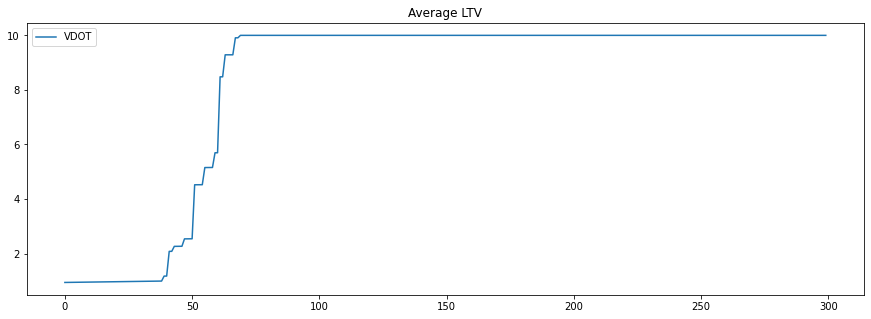

In [299]:
plt.figure(figsize=(15, 5))
for tkn in ['VDOT']:
    plt.plot(ltv_data[tkn], label=tkn)
plt.legend()
plt.title('Average LTV')
plt.show()

In [300]:
print([event.money_market.get_cdps(collateral_tkn='VDOT')[0].collateral_amt for event in events])
print([event.money_market.get_cdps(collateral_tkn='VDOT')[0].debt_amt for event in events])

[265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 265.95744680851067, 129.53578290703578, 129.53578290703578, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

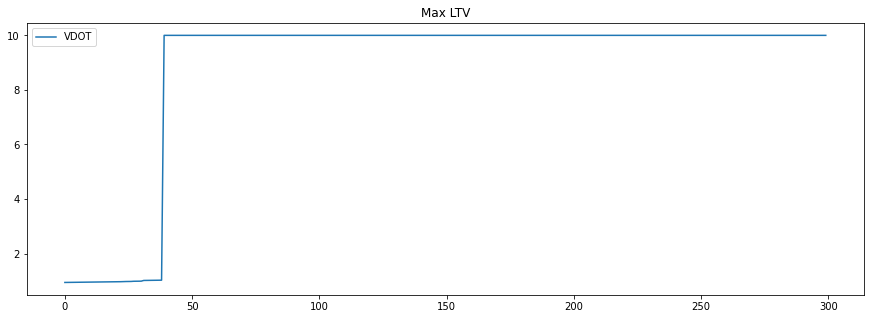

In [301]:
plt.figure(figsize=(15, 5))
for tkn in ['VDOT']:
    plt.plot(max_ltv_data[tkn], label=tkn)
plt.legend()
plt.title('Max LTV')
plt.show()

In [302]:
max_ltv_vdot = max_ltv_data['VDOT']
t_max = max_ltv_vdot.index(max(max_ltv_vdot))
print(max_ltv_vdot[98:102])
event_99 = events[99]
event_98 = events[98]

last_debt = [cdp.debt_amt for cdp in events[0].money_market.cdps]
last_collat = [cdp.collateral_amt for cdp in events[0].money_market.cdps]
for i in range(1, len(events)):
    for j in range(len(events[i].money_market.cdps)):
        if events[i].money_market.cdps[j].debt_amt > last_debt[j]:
            raise ValueError(f'CDP {j} changed at time {i}')
        if events[i].money_market.cdps[j].collateral_amt > last_collat[j]:
            raise ValueError(f'CDP {j} changed at time {i}')
        last_debt[j] = events[i].money_market.cdps[j].debt_amt
        last_collat[j] = events[i].money_market.cdps[j].collateral_amt
print(last_debt)


[10, 10, 10, 10]
[9.394940095263792, 3.219749771090818, 6.738802269497569, 6.701226272608977, 10.236157720437546, 0.17136087243926346, 7.0870751219786285, 6.701226272608977, 12.890588570683605, 13.790517112364995, 13.903189899925223, 2.968121522459569, 10.760276576015983, 4.463343507946206, 13.903189899925223, 12.890588570683605, 3.134282958257856, 5.3491197569821765, 12.890588570683605, 10.268701435630362, 8.521279244988193, 3.57391000219679, 7.556352837102921, 1.6863270547183902, 12.109013335832117, 3.672324935449268, 17.49216224349169, 3.321217333059515, 5.886222704826054, 2.5219315172472534, 6.738802269497569, 9.352272376822498, 1.9121884778321956, 11.142563283426625, 6.701226272608977, 5.349638703385978, 11.120144747727409, 2.966895389884826, 13.903189899925223, 3.3328887324679783, 6.701226272608977, 6.236137844104576, 6.673122060486989, 5.482596441878329, 3.321217333059515, 4.482318899823767, 1.3246816315338776, 5.7928627761859985, 6.738802269497569, 12.890588570683605, 5.7928627

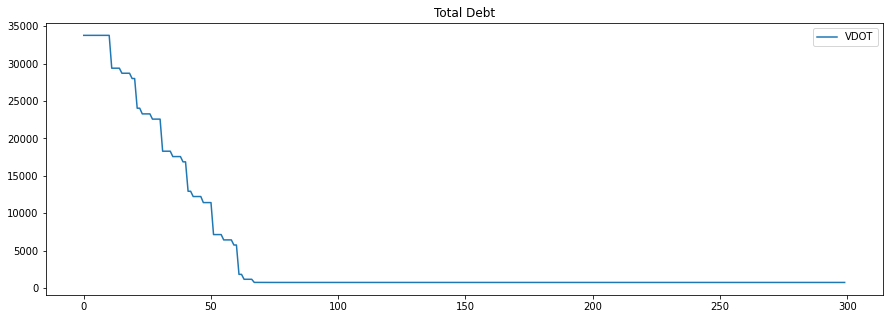

735.8296202816616


In [307]:
plt.figure(figsize=(15, 5))
for tkn in ['VDOT']:
    tkn_debt = []
    for event in events:
        tkn_debt.append(sum([cdp.debt_amt for cdp in event.money_market.get_cdps(collateral_tkn=tkn)]))
    # tkn_debt = [event.money_market.get_cdps(collateral_tkn=tkn)[0][1].debt_amt for event in events]
    plt.plot(tkn_debt, label=tkn)
plt.legend()
plt.title('Total Debt')
plt.show()
print(tkn_debt[-1])

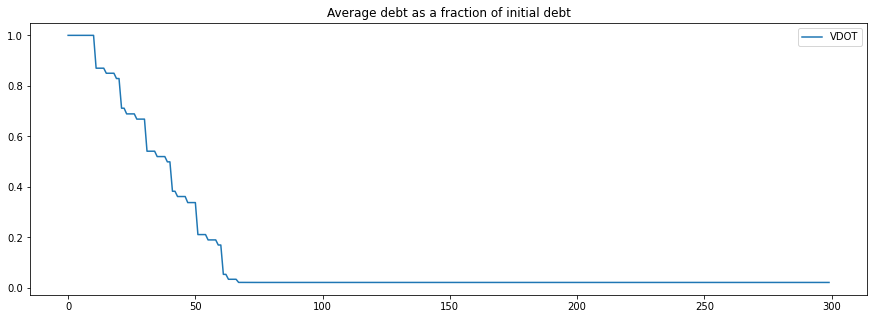

In [304]:
plt.figure(figsize=(15, 5))
total_debt_data = {'VDOT': []}
init_debt_data = [cdp.debt_amt for cdp in events[0].money_market.cdps]
for event in events:
    total_tkn_debt = {tkn: 0 for tkn in ['VDOT']}
    total_cdp_ct = {tkn: 0 for tkn in ['VDOT']}
    for i in range(len(event.money_market.cdps)):
        cdp = event.money_market.cdps[i]
        total_tkn_debt[cdp.collateral_asset] += cdp.debt_amt / init_debt_data[i] if init_debt_data[i] > 0 else 0
        total_cdp_ct[cdp.collateral_asset] += 1
    for tkn in ['VDOT']:
        total_debt_data[tkn].append(total_tkn_debt[tkn] / total_cdp_ct[tkn])
for tkn in ['VDOT']:
    plt.plot(total_debt_data[tkn], label=tkn)
plt.legend()
plt.title('Average debt as a fraction of initial debt')
plt.show()

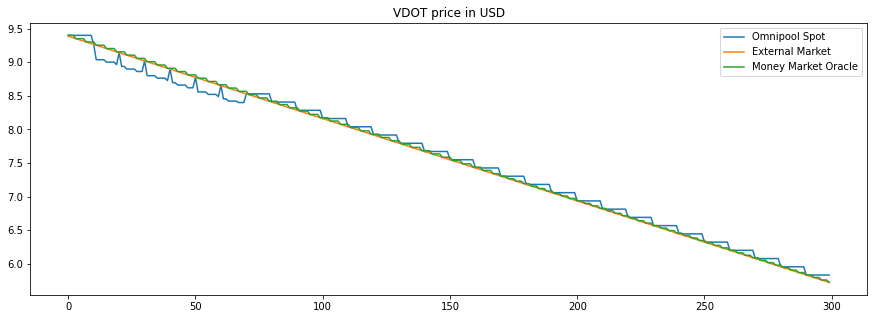

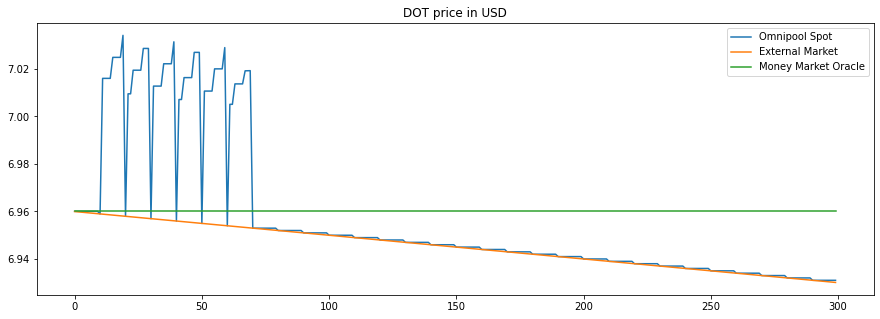

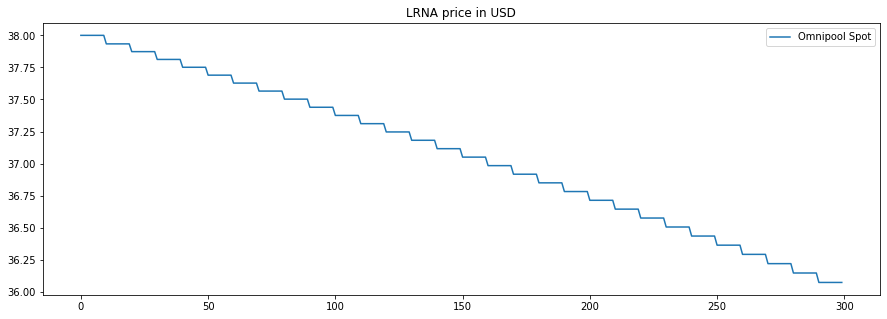

In [305]:
for tkn in ['VDOT', 'DOT', 'LRNA']:
    plt.figure(figsize=(15, 5))
    plt.plot([event.pools['omnipool'].price(event.pools['omnipool'], tkn, 'USDT') for event in events], label='Omnipool Spot')
    if tkn != 'LRNA':
        plt.plot([event.external_market[tkn] for event in events], label='External Market')
        plt.plot([event.money_market.oracles[(tkn, 'USDT')] for event in events], label='Money Market Oracle')
    plt.title(f'{tkn} price in USD')
    plt.legend()
    plt.show()

# Creating synthetic price data for simulation 2

301
[60000, 60000, 60000, 60000, 60000]
[60000, 60000, 60000, 60000, 60000]


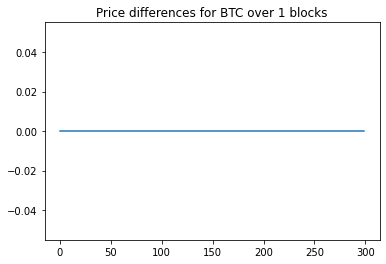

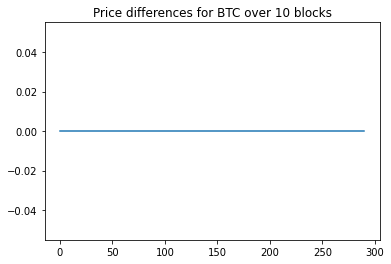

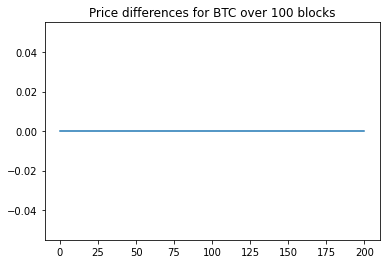

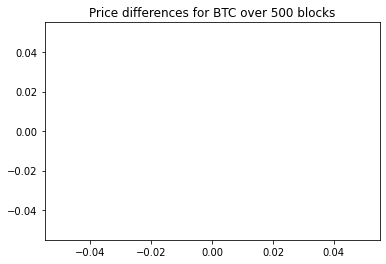

ValueError: min() arg is an empty sequence

In [306]:
btc_prices = [prices['BTC'] for prices in price_list_padded]
print(len(btc_prices))
print(btc_prices[0:5])
print(btc_prices[-5:])
price_diffs = {}

for b_ct in [1,10,100,500]:
    price_diffs[b_ct] = [(btc_prices[i+b_ct] - btc_prices[i])/btc_prices[i] for i in range(len(btc_prices)-b_ct)]
    plt.plot(price_diffs[b_ct])
    plt.title(f'Price differences for BTC over {b_ct} blocks')
    plt.show()
    
biggest_drop = {}
biggest_spike = {}
for b_ct in [1,10,100,500]:
    biggest_drop[b_ct] = min(price_diffs[b_ct])
    biggest_spike[b_ct] = max(price_diffs[b_ct])

print(biggest_drop)
print(biggest_spike)


print({b_ct: biggest_drop[b_ct]/b_ct for b_ct in biggest_drop})
print({b_ct: biggest_spike[b_ct]/b_ct for b_ct in biggest_spike})


In [ ]:
biggest_drop_dict = {'BTC': 0, 'ETH': 0, 'DOT': 0}
biggest_spike_dict = {'BTC': 0, 'ETH': 0, 'DOT': 0}

for tkn in ['BTC', 'ETH', 'DOT']:
    
    tkn_prices = [prices[tkn] for prices in price_list_padded]
    print(len(tkn_prices))
    print(tkn_prices[0:5])
    print(tkn_prices[-5:])
    price_diffs = {}
    
    for b_ct in [1,10,100,500]:
        price_diffs[b_ct] = [(tkn_prices[i+b_ct] - tkn_prices[i])/tkn_prices[i] for i in range(len(tkn_prices)-b_ct)]
        plt.plot(price_diffs[b_ct])
        plt.title(f'Price differences for {tkn} over {b_ct} blocks')
        plt.show()
        
    biggest_drop = {}
    biggest_spike = {}
    for b_ct in [1,10,100,500]:
        biggest_drop[b_ct] = min(price_diffs[b_ct])
        biggest_spike[b_ct] = max(price_diffs[b_ct])
    
    print(biggest_drop)
    print(biggest_spike)
    
    drop_per_block = {b_ct: biggest_drop[b_ct]/b_ct for b_ct in biggest_drop}
    spike_per_block = {b_ct: biggest_spike[b_ct]/b_ct for b_ct in biggest_spike}
    biggest_drop_dict[tkn] = drop_per_block
    biggest_spike_dict[tkn] = spike_per_block
    print(drop_per_block)
    print({b_ct: biggest_spike[b_ct]/b_ct for b_ct in biggest_spike})


In [ ]:
biggest_drop_dict_10 = {tkn: biggest_drop_dict[tkn][10] for tkn in biggest_drop_dict}
print(biggest_drop_dict_10)
biggest_spike_dict_10 = {tkn: biggest_spike_dict[tkn][10] for tkn in biggest_spike_dict}
print(biggest_spike_dict_10)

In [ ]:
from pprint import pprint
pprint(biggest_drop_dict_10)

price_dict_synthetic = {'BTC': [], 'ETH': [], 'DOT': []}
sim_block_ct = 2000
for tkn in ['BTC', 'ETH', 'DOT']:
    price_dict_synthetic[tkn].append(price_list[0][tkn])
    for i in range(1, sim_block_ct):
        if i % 10 == 0:
            price_dict_synthetic[tkn].append(price_dict_synthetic[tkn][-1] * (1 + biggest_drop_dict_10[tkn]))
        else:
            price_dict_synthetic[tkn].append(price_dict_synthetic[tkn][-1])
            
# pprint(price_list_synthetic[0:20])
pprint({tkn: price_dict_synthetic[tkn][-1] for tkn in ['BTC', 'ETH', 'DOT']})

price_list_synthetic = [{tkn: price_dict_synthetic[tkn][i] for tkn in ['BTC', 'ETH', 'DOT']} for i in range(len(price_dict_synthetic['BTC']))]
for d in price_list_synthetic:
    d['HDX'] = 0.015
pprint(price_list_synthetic[8:12])
    

# Simulation 2: Synthetic severe BTC price crash

In [ ]:


assets = {
    'HDX': {'usd price': price_list_synthetic[0]['HDX'], 'weight': 0.05},
    'USDT': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': price_list_synthetic[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list_synthetic[0]['ETH'], 'weight': 0.10},
    'DOT': {'usd price': price_list_synthetic[0]['DOT'], 'weight': 0.40},
}

liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd
    
omnipool = OmnipoolState(
        tokens={
            tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
        },
        lrna_fee=0.0005,
        asset_fee=0.0025,
        preferred_stablecoin='USDT',
    )

init_ltv = {'BTC': .79, 'ETH': .79, 'DOT': .74, 'USDC': .94}
pct_of_omnipool = 1
cdps = []
cdp_ct = 100
for tkn in ['BTC', 'ETH', 'DOT']:
    collat = pct_of_omnipool * omnipool.liquidity[tkn] / cdp_ct
    debt = collat * price_list_synthetic[0][tkn] * init_ltv[tkn]
    for i in range(cdp_ct):
        cdp_init = CDP('USDT', tkn, debt, collat)
        cdps.append(cdp_init)
mm = MoneyMarket(
    liquidity={"USDT": 1000000, "BTC": 1000, "ETH": 10000, "DOT": 100000},
    oracles={
        ("BTC", "USDT"): price_list_synthetic[0]['BTC'],
        ("ETH", "USDT"): price_list_synthetic[0]['ETH'],
        ("DOT", "USDT"): price_list_synthetic[0]['DOT'],
    },
    liquidation_threshold={'BTC': .8, 'ETH': .8, 'DOT': .75, 'USDT': .9},
    full_liquidation_threshold={'BTC': .8/.95, 'ETH': .8/.95, 'DOT': .75/.95, 'USDT': .9/.95},
    partial_liquidation_pct=0.5,
    cdps=cdps,
    liquidation_penalty={'BTC': .05, 'ETH': .05, 'DOT': .07, 'USDT': .03},
)

init_money_market = mm.copy()


initial_state = GlobalState(
    pools={'omnipool': omnipool},
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USDT': 1000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'ETH': 1000000000, 'BTC': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3,
                frequency=arb_freq
            )
        ),
    },
    evolve_function=update_prices_and_process('omnipool', 'Arbitrageur', price_list_synthetic, "USDT", 0.005),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    money_market=mm,
)

init_global_state = initial_state.copy()

time_steps = len(price_list_synthetic)-1
print(cdp_init)

In [ ]:
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
print(len(events))

In [ ]:
ltv_data = {'BTC': [], 'ETH': [], 'DOT': []}
max_ltv_data = {'BTC': [], 'ETH': [], 'DOT': []}
for event in events:
    for tkn in ['BTC', 'ETH', 'DOT']:
        tkn_cdps = event.money_market.get_cdps(collateral_tkn=tkn)
        ltv_list = [(cdp.debt_amt / cdp.collateral_amt / event.external_market[tkn] if cdp.collateral_amt > 0 else 2) for cdp in tkn_cdps ]
        average_ltv = sum(ltv_list) / len(tkn_cdps)
        max_ltv = max(ltv_list)
        ltv_data[tkn].append(average_ltv)
        max_ltv_data[tkn].append(max_ltv)
print([ltv_data[tkn][-1] for tkn in ['BTC', 'ETH', 'DOT']])
max_ltv = {'BTC': None, 'ETH': None, 'DOT': None}
for tkn in ['BTC', 'ETH', 'DOT']:
    max_ltv[tkn] = max(ltv_data[tkn])
print(max_ltv)

In [ ]:
plt.figure(figsize=(15, 5))
for tkn in ['BTC', 'ETH', 'DOT']:
    plt.plot(ltv_data[tkn], label=tkn)
plt.legend()
plt.title('Average LTV')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
for tkn in ['BTC', 'ETH', 'DOT']:
    plt.plot(max_ltv_data[tkn], label=tkn)
plt.legend()
plt.title('Max LTV')
plt.show()

In [ ]:
for tkn in ['BTC', 'ETH', 'DOT', 'LRNA']:
    plt.figure(figsize=(15, 5))
    plt.plot([event.pools['omnipool'].price(event.pools['omnipool'], tkn, 'USDT') for event in events], label='Omnipool Spot')
    if tkn != 'LRNA':
        plt.plot([event.external_market[tkn] for event in events], label='External Market')
        plt.plot([event.money_market.oracles[(tkn, 'USDT')] for event in events], label='Money Market Oracle')
    plt.title(f'{tkn} price in USDT')
    plt.legend()
    plt.show()